In [1]:
import pandas as pd 
import numpy as np 
import wandb 
from kaggle_secrets import UserSecretsClient
import matplotlib.pyplot as plt 
import seaborn as sns 
import cv2
from PIL import Image 
from wordcloud import WordCloud 
from glob import glob 

from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE 

# Setup tools 

In [2]:
user_secrets = UserSecretsClient()
wandb_api = user_secrets.get_secret("wandb_api") 
wandb.login(key=wandb_api)

wandb: W&B API key is configured (use `wandb login --relogin` to force relogin)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publically.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
config = dict(
    competition="Pawpularity", 
    infra = "kaggle",
    seed = 42 
)
run = wandb.init(project="Pawpularity", 
          config=config, 
          group="None",
          job_type="EDA")

wandb: Currently logged in as: kooose (use `wandb login --relogin` to force relogin)
2021-09-27 13:17:04.041563: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-09-27 13:17:04.041677: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# EDA 

In [4]:
train = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
test = pd.read_csv("../input/petfinder-pawpularity-score/train.csv")
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Pawpularity'>

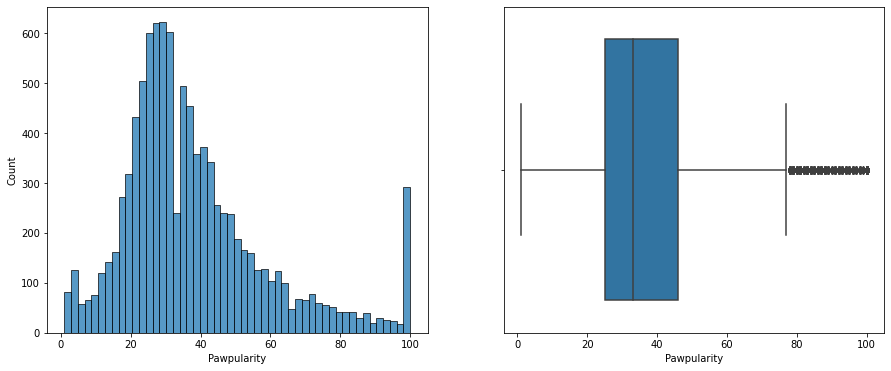

In [5]:

'''
The part that is partially raised at the end is conspicuous
'''

plt.figure(figsize=(15, 6))
plt.subplot(121)
sns.histplot(train.Pawpularity)
plt.subplot(122)
sns.boxplot(train.Pawpularity)

In [6]:
train.corr().loc[:, ["Pawpularity"]].style.background_gradient(cmap="coolwarm")

,Pawpularity
Subject Focus,-0.009853
Eyes,-0.006686
Face,0.008018
Near,0.001001
Action,-0.001373
Accessory,0.013287
Group,0.016469
Collage,0.001732
Human,0.003983
Occlusion,0.001979


In [7]:
train.isnull().sum() / train.shape[0]

Id               0.0
Subject Focus    0.0
Eyes             0.0
Face             0.0
Near             0.0
Action           0.0
Accessory        0.0
Group            0.0
Collage          0.0
Human            0.0
Occlusion        0.0
Info             0.0
Blur             0.0
Pawpularity      0.0
dtype: float64

In [8]:

'''
merge data (dog and cat)? 
'''

dog_cat = pd.read_csv("../input/pawpularity-cat-or-dog/cat_class.csv")

train = pd.merge(train, dog_cat, how="left", on="Id")
train.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,is_cat
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63,0
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42,1
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28,0
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15,0
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72,0


In [9]:
train.groupby("is_cat").mean().style.background_gradient(cmap="coolwarm")

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
is_cat,,,,,,,,,,,,,
0,0.016762,0.736656,0.889060,0.860388,0.007940,0.074989,0.115351,0.063961,0.202029,0.204676,0.077195,0.065505,42.129687
1,0.036817,0.802901,0.916512,0.862588,0.011714,0.061733,0.141131,0.037560,0.136110,0.144478,0.047787,0.074563,34.590368


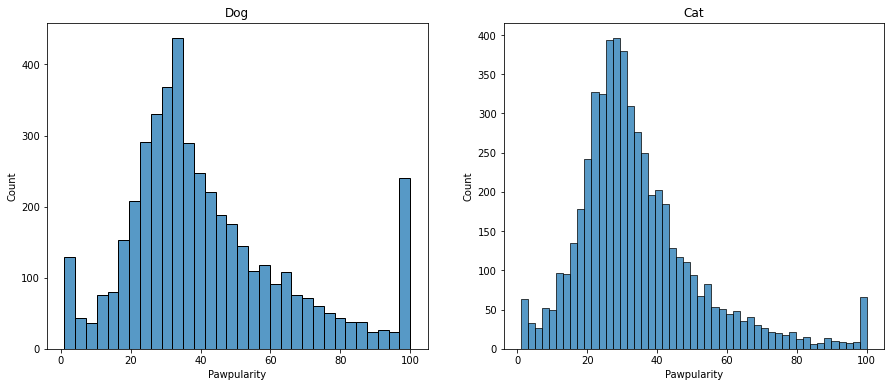

In [10]:
plt.figure(figsize=(15, 6))

plt.subplot(121)
sns.histplot(train.loc[train.is_cat == 0, "Pawpularity"])
plt.title("Dog")
plt.subplot(122)
sns.histplot(train.loc[train.is_cat == 1, "Pawpularity"])
plt.title("Cat")
plt.show()

# Show image Under/Top

In [11]:

# add file path 
train["img_file"] = [f"../input/petfinder-pawpularity-score/train/{f}.jpg" for f in train.Id]
test["img_file"] = [f"../input/petfinder-pawpularity-score/test/{f}.jpg" for f in test.Id]


def viz_rank_img(type="dog", ascending=True, n=9):
    x = train[train.is_cat == (0 if type == "dog" else 1)].sort_values("Pawpularity", ascending=ascending)[:n]
    x_img = x["img_file"].to_list()
    
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    ax = axes.ravel()
    for i in range(n):
        img = cv2.imread(x_img[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        ax[i].imshow(img)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.title(type)
    plt.show()
    
    
'''
I looked at some of the images but couldn't figure out 
how they affected the objective variable.
'''

"\nI looked at some of the images but couldn't figure out \nhow they affected the objective variable.\n"

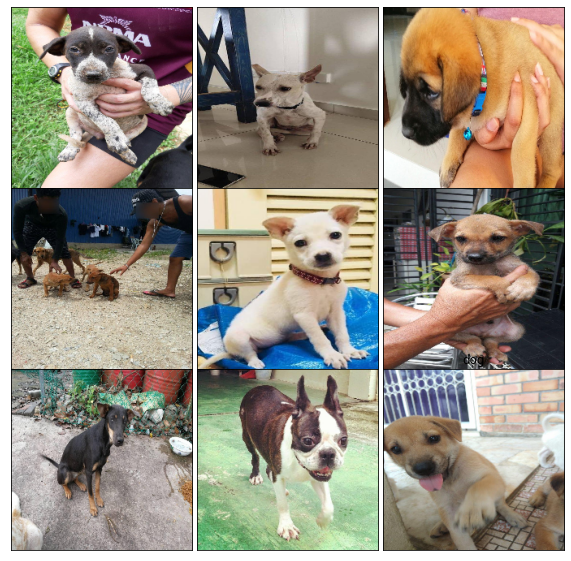

In [12]:
viz_rank_img() # Under 10 category dog 

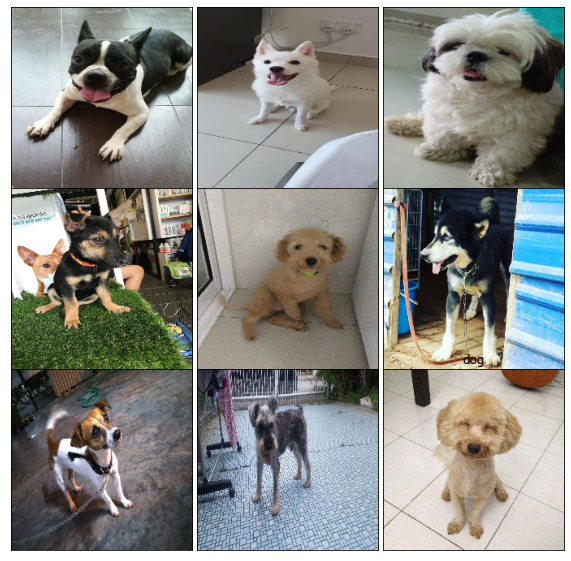

In [13]:
viz_rank_img(ascending=False) # top 10 category dog 


CondaEnvException: Unable to determine environment

Please re-run this command with one of the following options:

* Provide an environment name via --name or -n
* Re-run this command inside an activated conda environment.



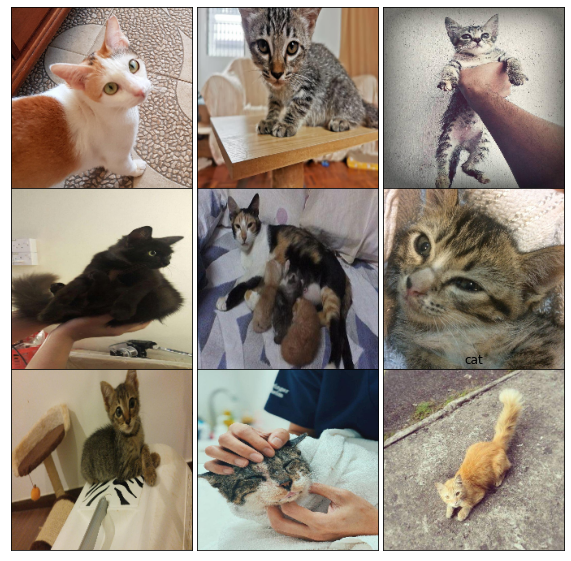

In [14]:
viz_rank_img(type="cat") # under 10 category cat 

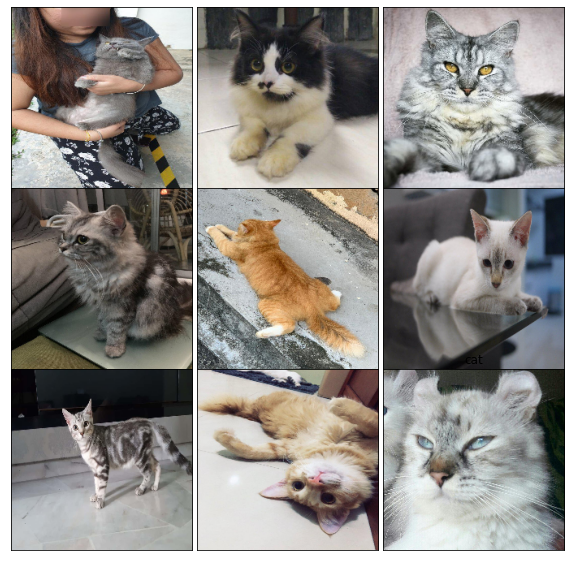

In [15]:
viz_rank_img(type="cat", ascending=False) # top 10 category cat 

# T-SNE and Clustering 

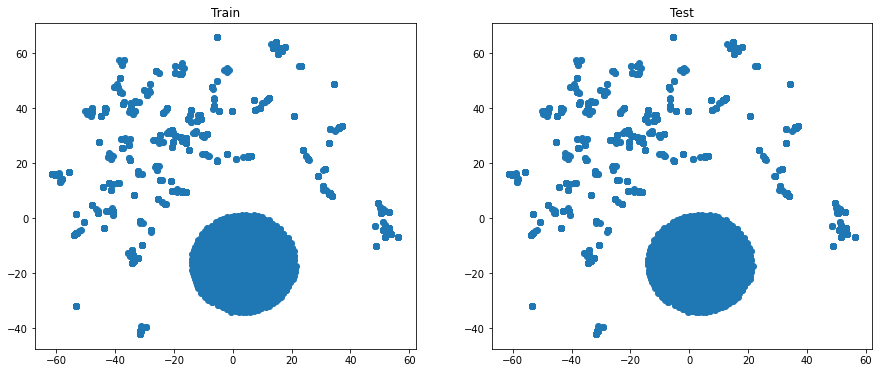

In [16]:

'''
Some parts are cohesive and some are not.
'''

use_col = ['Subject Focus', 'Eyes', 'Face', 'Near', 'Action', 'Accessory',
       'Group', 'Collage', 'Human', 'Occlusion', 'Info', 'Blur']

tsne = TSNE(n_components=2, random_state=config["seed"])

t_train = tsne.fit_transform(train[use_col])
t_test = tsne.fit_transform(test[use_col])

plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title("Train")
plt.scatter(x=t_train[:, 0], y=t_train[:, 1])
plt.subplot(122)
plt.title("Test")
plt.scatter(x=t_test[:, 0], y=t_test[:, 1])

<AxesSubplot:title={'center':'Test'}, xlabel='c0', ylabel='c1'>

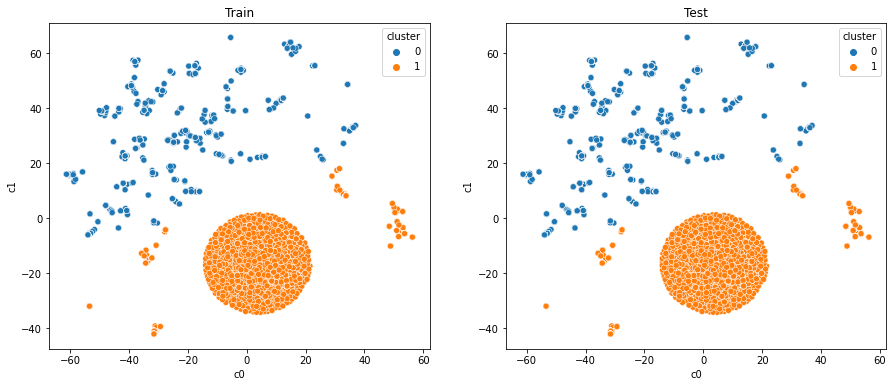

In [17]:

# tsne dataframe 
t_train = pd.DataFrame(t_train, index=train.Id, columns=["c"+str(c) for c in range(2)])
t_test = pd.DataFrame(t_test, index=test.Id, columns=["c"+str(c) for c in range(2)])

km = KMeans(n_clusters=2, random_state=config["seed"]).fit(t_train)
y_km = km.predict(t_train)
y_km_ = km.predict(t_test)

t_train["cluster"] = y_km 
t_test["cluster"] = y_km_ 


plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.title("Train")
sns.scatterplot(data=t_train, x="c0", y="c1", hue="cluster")
plt.subplot(122)
plt.title("Test")
sns.scatterplot(data=t_test, x="c0", y="c1", hue="cluster")

In [18]:

train = pd.merge(train, t_train.reset_index().drop(["c0", "c1"], axis=1), how="left", on="Id")
test = pd.merge(test, t_test.reset_index().drop(["c0", "c1"], axis=1), how="left", on="Id")


def show_cloud(cnt2animal, c):
    word = WordCloud(background_color="white", contour_color="blue", width=1500, height=750).generate_from_frequencies(cnt2animal)
    plt.imshow(word)
    plt.title(f"Cluster={c}")
    plt.axis("off")
    plt.show()
    
def find_cluster_feature(c_name = 1):
    c = train[train.cluster == c_name]
    cnt2animal = {}
    for animal in c.is_cat.to_list():
        text = "dog" if animal == 0 else "cat"
        if text not in cnt2animal:
            cnt2animal[text] = 1 
        else:
            cnt2animal[text] += 1 
    show_cloud(cnt2animal, c_name)
    
    use_col_ = use_col.copy()
    use_col_.append("Pawpularity")
  
    for col in use_col_:
        feature_mu = c[col].mean()
        cnt2animal[col] = feature_mu 
    return pd.DataFrame({"feature": [k for k, v in cnt2animal.items()], 
                         "mean": [v for  k, v in cnt2animal.items()]}).style.background_gradient(cmap="coolwarm")


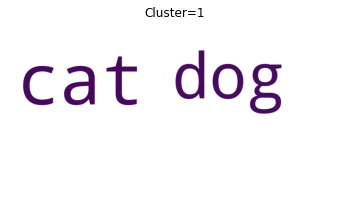

,feature,mean
0,dog,2411.000000
1,cat,3042.000000
2,Subject Focus,0.001284
3,Eyes,0.847423
4,Face,0.920594
5,Near,1.000000
6,Action,0.002567
7,Accessory,0.009719
8,Group,0.079039
9,Collage,0.001284


In [19]:
find_cluster_feature()

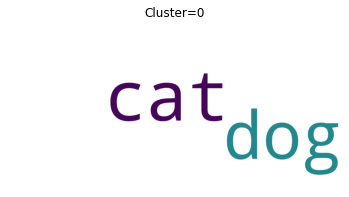

,feature,mean
0,cat,2336.000000
1,dog,2123.000000
2,Subject Focus,0.059879
3,Eyes,0.681094
4,Face,0.883606
5,Near,0.692308
6,Action,0.019063
7,Accessory,0.138820
8,Group,0.190850
9,Collage,0.108769


In [20]:

'''
The level of each feature is lower than that of cluster 1.
There is no count difference between dogs and cats and objective variables.
'''

find_cluster_feature(0)

In [21]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)

for f in glob("*.csv"):
    artifact = wandb.Artifact(name='eda', type='dataset')
    artifact.add_file(f)
    run.log_artifact(artifact)